In [1]:
#=======================================================
# 1. ANÁLISE DE METADADOS DOS DATASETS
#=======================================================

import pandas as pd
import os

# Configurações de diretórios
diretorio_dados = os.path.join(os.getcwd(), 'dados')
diretorio_saida = os.path.join(os.getcwd(), 'pre_analise')
arquivo_saida = os.path.join(diretorio_saida, 'analise_metadados_datasets.xlsx')

arquivos = {
    'emprestimos': 'emprestimos.csv',
    'serasa': 'serasa.csv',
    'anteriores': 'emprestimos_anteriores.csv'
}

# Criar pasta pre_analise se não existir
if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)

def analisar_dataframe(nome, path):
    full_path = os.path.join(diretorio_dados, path)
    
    if not os.path.exists(full_path):
        print(f"Aviso: Arquivo {path} não encontrado.")
        return None

    # Carregando apenas as primeiras linhas para análise de metadados
    df = pd.read_csv(full_path, sep=';', encoding='utf-8', nrows=5)
    
    info_colunas = []
    
    for col in df.columns:
        dtype = df[col].dtype
        
        # Lógica de inferência estatística
        if dtype == 'object':
            tipo_estatistico = "Nominal/Categorizado"
            num_tipo = "Discreto"
        elif 'AMT' in col or 'SOURCE' in col:
            tipo_estatistico = "Racional"
            num_tipo = "Contínuo"
        elif 'DAYS' in col:
            tipo_estatistico = "Intervalar"
            num_tipo = "Discreto"
        elif 'CNT' in col or 'count' in col.lower() or 'Qtde' in col:
            tipo_estatistico = "Racional"
            num_tipo = "Discreto"
        else:
            tipo_estatistico = "Indeterminado (Requer inspeção)"
            num_tipo = "Discreto"
            
        origem = "Derivado" if (col.startswith('count') or col in ['Divida_atrasada', 'Qtde_emprestimos']) else "Univalorado/Original"

        info_colunas.append({
            "Atributo": col,
            "Dtype": str(dtype),
            "Escala": tipo_estatistico,
            "Natureza": origem,
            "Tipo Numérico": num_tipo
        })

    return pd.DataFrame(info_colunas)

# --- EXECUÇÃO E SALVAMENTO EM EXCEL ---

# O ExcelWriter permite criar múltiplas abas
with pd.ExcelWriter(arquivo_saida, engine='openpyxl') as writer:
    for nome, arquivo in arquivos.items():
        resultado = analisar_dataframe(nome, arquivo)
        
        if resultado is not None:
            # Salva cada análise em uma aba com o nome do dataset
            resultado.to_excel(writer, sheet_name=nome, index=False)
            print(f"Análise de '{nome}' processada e adicionada ao Excel.")

print(f"\n[SUCESSO] Tabela consolidada criada em: {arquivo_saida}")

Análise de 'emprestimos' processada e adicionada ao Excel.
Análise de 'serasa' processada e adicionada ao Excel.
Análise de 'anteriores' processada e adicionada ao Excel.

[SUCESSO] Tabela consolidada criada em: c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\pre_analise\analise_metadados_datasets.xlsx


In [2]:
#=======================================================
# 2. TRATAMENTO DE QUALIDADE DOS DATASETS 
#=======================================================

import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configurações de diretório
diretorio = 'dados'
diretorio_saida = 'pre_analise' 
arquivos = ['emprestimos.csv', 'serasa.csv', 'emprestimos_anteriores.csv']
na_list = ["", " ", "  ", "\t", "?", "-", "--", "---", "NA", "N/A", "na", "n/a", "NULL", "null", "None", "nan", "NaN", "NAN"]

if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)

def refatorar_processamento_completo(nome_arq):
    caminho = os.path.join(diretorio, nome_arq)
    if not os.path.exists(caminho):
        return None

    # 1. Carregamento
    df = pd.read_csv(caminho, sep=';', na_values=na_list, keep_default_na=True)
    
    relatorio = {
        "dataset": nome_arq,
        "linhas_iniciais": len(df),
        "atributos_iniciais": len(df.columns),
        "linhas_duplicadas_removidas": 0,
        "celulas_nulas_preenchidas": 0,
        "linhas_afetadas_por_nulos": 0,
        "linhas_removidas_ausentes": 0,
        "cols_normalizadas": [],
        "cols_discretizadas": [],
        "cols_encodadas": [],
        "outliers_totais": 0,
        "detalhe_outliers": {}, # Qualificação dos outliers por atributo
        "linhas_finais": 0,
        "consolidado_por_id": False
    }

    # 2. Registros Duplicados
    duplicados = df.duplicated().sum()
    df = df.drop_duplicates()
    relatorio["linhas_duplicadas_removidas"] = duplicados

    # 3. Dados Ausentes (Células vs Linhas)
    relatorio["linhas_afetadas_por_nulos"] = df.isnull().any(axis=1).sum()
    for col in df.columns:
        nulos_count = df[col].isnull().sum()
        if nulos_count > 0:
            perc = (nulos_count / len(df)) * 100
            if perc < 5:
                relatorio["linhas_removidas_ausentes"] += nulos_count
                df = df.dropna(subset=[col])
            else:
                relatorio["celulas_nulas_preenchidas"] += nulos_count
                df[col] = df[col].fillna(0)

    # 4. Flags (Discretização)
    flags = ['TARGET', 'FLAG_OWN_CAR', 'FLAG_MOBIL', 'NFLAG_INSURED_ON_APPROVAL', 'FLAG_EMP_PHONE', 'FLAG_EMAIL']
    for f in flags:
        if f in df.columns:
            if df[f].dtype == 'object':
                df[f] = df[f].astype(str).str.strip().str.upper().map({'Y': 1, 'N': 0, 'S': 1, 'T': 1, 'F': 0, '1': 1, '0': 0}).fillna(0).astype(int)
            else:
                df[f] = df[f].fillna(0).astype(int)
            relatorio["cols_discretizadas"].append(f)

    # 5. Normalização Semântica
    cols_texto = df.select_dtypes(include=['object']).columns
    for col in cols_texto:
        if col not in flags:
            df[col] = df[col].astype(str).str.strip().str.capitalize()

    # 6. IDENTIFICAÇÃO E QUALIFICAÇÃO DE OUTLIERS (IQR)
    # Valores são MANTIDOS (não há np.where para tratamento)
    cols_numericas = df.select_dtypes(include=[np.number]).columns
    for col in cols_numericas:
        if 'ID' in col or 'TARGET' in col or col in flags: continue
        
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        l_inf, l_sup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        
        fora_inf = (df[col] < l_inf).sum()
        fora_sup = (df[col] > l_sup).sum()
        qtd_out = fora_inf + fora_sup
        
        if qtd_out > 0:
            relatorio["outliers_totais"] += qtd_out
            relatorio["detalhe_outliers"][col] = {
                'total': int(qtd_out),
                'abaixo_min': int(fora_inf),
                'acima_max': int(fora_sup)
            }

    # 7. Encoding
    le = LabelEncoder()
    cols_para_encode = df.select_dtypes(include=['object']).columns
    for col in cols_para_encode:
        df[col] = le.fit_transform(df[col])
        relatorio["cols_encodadas"].append(col)

    # 8. Normalização (Scale)
    cols_racionais = [c for c in df.columns if 'AMT' in c or 'EXT_SOURCE' in c]
    if cols_racionais:
        scaler = StandardScaler()
        df[cols_racionais] = scaler.fit_transform(df[cols_racionais].fillna(0))
        relatorio["cols_normalizadas"] = cols_racionais

    # 9. Agregação
    if nome_arq in ['serasa.csv', 'emprestimos_anteriores.csv'] and 'SK_ID_CURR' in df.columns:
        relatorio["consolidado_por_id"] = True
        agg_map = {col: ('count' if ('ID' in col or col in flags) else 'mean') for col in df.columns if col != 'SK_ID_CURR'}
        df = df.groupby('SK_ID_CURR').agg(agg_map).reset_index()

    relatorio["linhas_finais"] = len(df)
    df.to_csv(os.path.join(diretorio_saida, f"limpo_{nome_arq}"), sep=';', index=False)
    return relatorio

# --- EXECUÇÃO E IMPRESSÃO DO RELATÓRIO ---
resultados = [refatorar_processamento_completo(arq) for arq in arquivos]

print(f"\n{'='*85}")
print(f"{'RELATÓRIO DE QUALIDADE: IDENTIFICAÇÃO E QUALIFICAÇÃO DE OUTLIERS':^85}")
print(f"{'='*85}")

for r in resultados:
    if r is None: continue
    print(f"\nDATASET: {r['dataset']}")
    print(f"  [VOLUMETRIA DE LINHAS]")
    print(f"  - Linhas Iniciais: {r['linhas_iniciais']} | Finais: {r['linhas_finais']}")
    
    print(f"\n  [SANEAMENTO DE NULOS]")
    print(f"  - Células Preenchidas (Zero): {r['celulas_nulas_preenchidas']}")
    print(f"  - Linhas Removidas (< 5%): {r['linhas_removidas_ausentes']}")
    
    print(f"\n  [QUALIFICAÇÃO DE OUTLIERS (Mantidos na base)]")
    print(f"  - Total de Outliers Identificados: {r['outliers_totais']}")
    if r['detalhe_outliers']:
        print(f"  - Detalhamento por Atributo:")
        for col, d in r['detalhe_outliers'].items():
            print(f"    * {col:25} | Total: {d['total']:6} | (Abaixo: {d['abaixo_min']:6} | Acima: {d['acima_max']:6})")
    
    print(f"\n  [TRANSFORMAÇÕES]")
    print(f"  - Colunas Normalizadas (Scale): {len(r['cols_normalizadas'])}")
    print(f"  - Colunas Encodadas (Label): {len(r['cols_encodadas'])}")
    print(f"{'-'*85}")


          RELATÓRIO DE QUALIDADE: IDENTIFICAÇÃO E QUALIFICAÇÃO DE OUTLIERS           

DATASET: emprestimos.csv
  [VOLUMETRIA DE LINHAS]
  - Linhas Iniciais: 307511 | Finais: 306851

  [SANEAMENTO DE NULOS]
  - Células Preenchidas (Zero): 330504
  - Linhas Removidas (< 5%): 660

  [QUALIFICAÇÃO DE OUTLIERS (Mantidos na base)]
  - Total de Outliers Identificados: 105211
  - Detalhamento por Atributo:
    * CNT_CHILDREN              | Total:   4263 | (Abaixo:      0 | Acima:   4263)
    * AMT_INCOME_TOTAL          | Total:  14017 | (Abaixo:      0 | Acima:  14017)
    * AMT_CREDIT                | Total:   6559 | (Abaixo:      0 | Acima:   6559)
    * REGION_RATING_CLIENT      | Total:  80372 | (Abaixo:  32127 | Acima:  48245)

  [TRANSFORMAÇÕES]
  - Colunas Normalizadas (Scale): 5
  - Colunas Encodadas (Label): 8
-------------------------------------------------------------------------------------

DATASET: serasa.csv
  [VOLUMETRIA DE LINHAS]
  - Linhas Iniciais: 1716428 | Finais: 3058

In [3]:
# ====================================================
# 3. INTEGRAÇÃO DOS DATAFRAMES PROCESSADOS COM RELATÓRIO
# ====================================================

import pandas as pd
import os
from fpdf import FPDF

# Caminhos de diretório
PATH_INPUT = 'pre_analise/'
PATH_FINAL = 'integracao/'

if not os.path.exists(PATH_FINAL):
    os.makedirs(PATH_FINAL)

class RelatorioErro(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Relatório de Inconsistências de SK_ID_CURR', 0, 1, 'C')
        self.ln(5)

def gerar_relatorio_e_integrar():
    print("Carregando bases de /pre_analise/...")
    try:
        df_passados = pd.read_csv(f'{PATH_INPUT}limpo_emprestimos_anteriores.csv', sep=';')
        df_serasa = pd.read_csv(f'{PATH_INPUT}limpo_serasa.csv', sep=';')
        df_emprestimo = pd.read_csv(f'{PATH_INPUT}limpo_emprestimos.csv', sep=';')
    except FileNotFoundError as e:
        print(f"Erro ao carregar arquivos: {e}")
        return None

    pdf = RelatorioErro()
    pdf.add_page()
    pdf.set_font("Arial", size=10)
    inconsistencia_detectada = False

    id_base = set(df_emprestimo['SK_ID_CURR'])

    # Verificações de inconsistência
    serasa_incomp = df_serasa[~df_serasa['SK_ID_CURR'].isin(id_base)]
    if not serasa_incomp.empty:
        inconsistencia_detectada = True
        pdf.cell(0, 10, 'Inconsistências no arquivo: limpo_serasa.csv', 0, 1)
        for idx, row in serasa_incomp.iterrows():
            pdf.cell(0, 7, f"Linha: {idx} | SK_ID_CURR: {row['SK_ID_CURR']}", 0, 1)
        pdf.ln(5)

    passados_incomp = df_passados[~df_passados['SK_ID_CURR'].isin(id_base)]
    if not passados_incomp.empty:
        inconsistencia_detectada = True
        pdf.cell(0, 10, 'Inconsistências no arquivo: limpo_emprestimos_anteriores.csv', 0, 1)
        for idx, row in passados_incomp.iterrows():
            pdf.cell(0, 7, f"Linha: {idx} | SK_ID_CURR: {row['SK_ID_CURR']}", 0, 1)

    # Agregações
    print("Agregando dados secundários...")
    serasa_agg = df_serasa.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'AMT_CREDIT_SUM_OVERDUE': 'sum',
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
        'DAYS_CREDIT': 'mean',
        'CREDIT_DAY_OVERDUE': 'max',
        'AMT_CREDIT_MAX_OVERDUE': 'sum'
    }).reset_index()
    serasa_agg.columns = ['SK_ID_CURR', 'Qtde_emprestimos', 'Divida_atrasada', 'Creditos_Ativos', 
                          'Media_Dias_Credito', 'Max_Dias_Atraso', 'Soma_Max_Atrasado']

    passados_agg = df_passados.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_APPLICATION': 'sum',
        'AMT_CREDIT': 'sum',
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Refused').mean(),
        'CODE_REJECT_REASON': lambda x: x.mode()[0] if not x.mode().empty else 'XAP',
        'NAME_GOODS_CATEGORY': lambda x: x.mode()[0] if not x.mode().empty else 'XNA'
    }).reset_index()
    passados_agg['Dif_Aprovado'] = passados_agg['AMT_APPLICATION'] - passados_agg['AMT_CREDIT']
    
    # Organização das colunas conforme sua lógica
    passados_agg = passados_agg[['SK_ID_CURR', 'SK_ID_PREV', 'AMT_APPLICATION', 'AMT_CREDIT', 
                                 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 'Dif_Aprovado']]
    passados_agg.columns = ['SK_ID_CURR', 'Total_Contratos_Passados', 'Soma_Solicitado', 'Soma_Concedido',
                            'Taxa_Recusa', 'Motivo_Rejeicao_Principal', 'Categoria_Bem_Frequente', 'Dif_Aprovado']

    # INTEGRAÇÃO FINAL
    print("Consolidando base única...")
    df_result = df_emprestimo.merge(serasa_agg, on='SK_ID_CURR', how='inner')
    df_result = df_result.merge(passados_agg, on='SK_ID_CURR', how='inner')

    df_result.to_csv(f'{PATH_FINAL}base_unica_integrada.csv', sep=';', index=False)
    
    if inconsistencia_detectada:
        pdf.output(f'{PATH_FINAL}relatorio_inconsistencias.pdf')
        print(f"Relatório de inconsistências salvo.")
    
    print(f"Integração concluída. Total de registros: {df_result.shape[0]}")
    return df_result # RETORNO ESSENCIAL

def calcular_impacto_outlier(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    
    grupo_outlier = df[df[coluna] > limite_superior]
    grupo_normal = df[df[coluna] <= limite_superior]
    
    if len(grupo_outlier) > 0:
        taxa_inad_outlier = grupo_outlier['TARGET'].mean()
        taxa_inad_normal = grupo_normal['TARGET'].mean()
        risco_relativo = taxa_inad_outlier / taxa_inad_normal if taxa_inad_normal > 0 else 0
        
        print(f"Atributo: {coluna}")
        print(f"  - Qtd Outliers: {len(grupo_outlier)}")
        print(f"  - Taxa de Inadimplência nos Outliers: {taxa_inad_outlier:.2%}")
        print(f"  - Taxa de Inadimplência nos Normais: {taxa_inad_normal:.2%}")
        print(f"  - IMPACTO: Outliers representam {risco_relativo:.2f}x mais risco.")
        print("-" * 50)

# ====================================================
# EXECUÇÃO DO PROCESSO (ORQUESTRAÇÃO)
# ====================================================

# 1. Executa a integração e guarda o resultado na variável global
df_integrado = gerar_relatorio_e_integrar()

# 2. Só executa a análise de outliers se a integração deu certo
if df_integrado is not None:
    print(f"\n{'='*20} ANÁLISE DE IMPACTO DE OUTLIERS {'='*20}\n")
    colunas_criticas = ['Divida_atrasada', 'Max_Dias_Atraso', 'AMT_INCOME_TOTAL', 'Soma_Max_Atrasado']

    for col in colunas_criticas:
        if col in df_integrado.columns:
            calcular_impacto_outlier(df_integrado, col)

Carregando bases de /pre_analise/...
Agregando dados secundários...
Consolidando base única...
Relatório de inconsistências salvo.
Integração concluída. Total de registros: 249048

==================== ANÁLISE DE IMPACTO DE OUTLIERS ====================

Atributo: Divida_atrasada
  - Qtd Outliers: 3175
  - Taxa de Inadimplência nos Outliers: 16.31%
  - Taxa de Inadimplência nos Normais: 7.73%
  - IMPACTO: Outliers representam 2.11x mais risco.
--------------------------------------------------
Atributo: Max_Dias_Atraso
  - Qtd Outliers: 3227
  - Taxa de Inadimplência nos Outliers: 15.96%
  - Taxa de Inadimplência nos Normais: 7.74%
  - IMPACTO: Outliers representam 2.06x mais risco.
--------------------------------------------------
Atributo: AMT_INCOME_TOTAL
  - Qtd Outliers: 11183
  - Taxa de Inadimplência nos Outliers: 6.06%
  - Taxa de Inadimplência nos Normais: 7.93%
  - IMPACTO: Outliers representam 0.76x mais risco.
--------------------------------------------------
Atributo: So

In [4]:
#===================================
# Teste de integridade da base única
#====================================

import pandas as pd
import os

# Configurações de diretório
PATH_INTEGRACAO = 'integracao/'
ARQUIVO_BASE = 'base_unica_integrada.csv'

def verificar_duplicados():
    caminho_arquivo = os.path.join(PATH_INTEGRACAO, ARQUIVO_BASE)
    
    if not os.path.exists(caminho_arquivo):
        print(f"Erro: O arquivo {ARQUIVO_BASE} não foi encontrado em {PATH_INTEGRACAO}")
        return

    # Carregar a base única
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    # 1. Verificar duplicidade na chave primária (SK_ID_CURR)
    total_registros = len(df)
    duplicados_id = df.duplicated(subset=['SK_ID_CURR'], keep=False).sum()
    
    # 2. Verificar duplicidade de linhas inteiras (Exatamente iguais)
    duplicados_completos = df.duplicated().sum()

    print(f"{'='*40}")
    print(f"VERIFICAÇÃO DE DUPLICIDADE: {ARQUIVO_BASE}")
    print(f"{'='*40}")
    print(f"Total de registros na base: {total_registros}")
    print(f"Linhas idênticas duplicadas: {duplicados_completos}")
    print(f"IDs (SK_ID_CURR) com duplicidade: {duplicados_id}")

    if duplicados_id > 0:
        print("\n[ALERTA] Foram encontrados IDs duplicados!")
        # Filtrar apenas os registros duplicados para inspeção
        df_duplicados = df[df.duplicated(subset=['SK_ID_CURR'], keep=False)].sort_values(by='SK_ID_CURR')
        
        # Salvar para análise manual
        caminho_check = os.path.join(PATH_INTEGRACAO, 'check_duplicados.csv')
        df_duplicados.to_csv(caminho_check, sep=';', index=False)
        print(f"Os registros duplicados foram salvos em: {caminho_check}")
    else:
        print("\n[SUCESSO] Não existem registros duplicados. A chave SK_ID_CURR é única.")
    
    print(f"{'='*40}")

# Executar a verificação
verificar_duplicados()

VERIFICAÇÃO DE DUPLICIDADE: base_unica_integrada.csv
Total de registros na base: 249048
Linhas idênticas duplicadas: 0
IDs (SK_ID_CURR) com duplicidade: 0

[SUCESSO] Não existem registros duplicados. A chave SK_ID_CURR é única.


c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\kensl\OneDrive\37_Sistema_de_Informacao\Curso\4o_Semestre\1_Disciplinas\Ciencia_de_Dados\Trabalho\Base_dados\Pre_Processamento\.venv\Lib\site-packages\numpy\lib\_functio

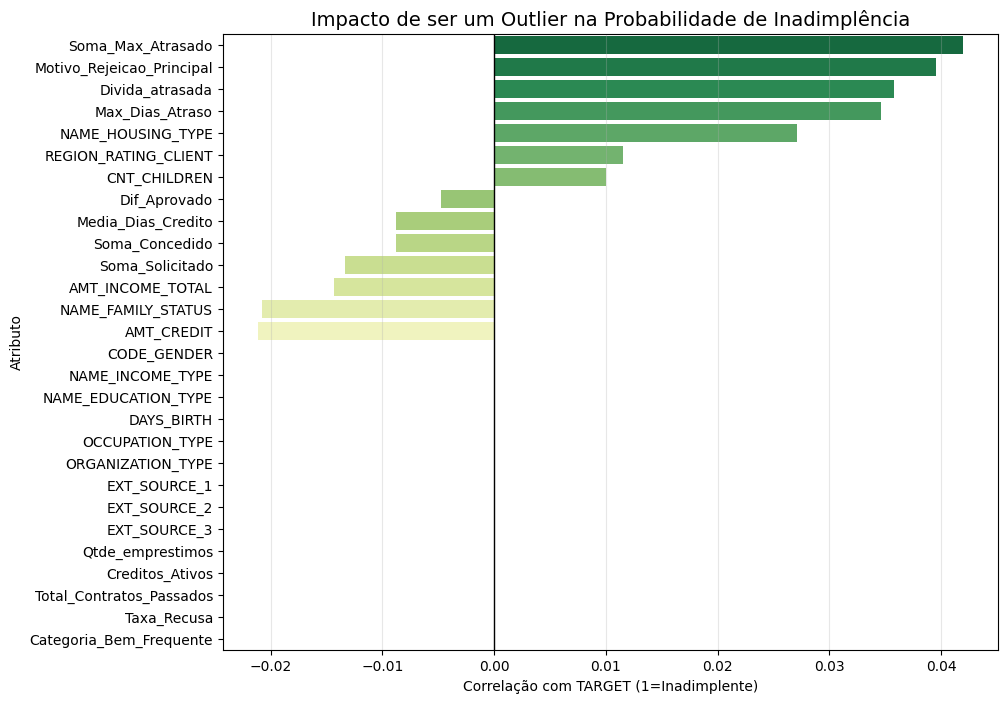

In [5]:
#=======================================================
# ANÁLISE DE CORRELAÇÃO: OUTLIERS VS. INADIMPLÊNCIA
#=======================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_correlacao_outliers(caminho_base_integrada):
    # 1. Carregar a base unificada
    df = pd.read_csv(caminho_base_integrada, sep=';')
    
    # 2. Identificar colunas numéricas (exceto IDs e TARGET)
    cols_numericas = df.select_dtypes(include=[np.number]).columns
    cols_analise = [c for c in cols_numericas if c not in ['SK_ID_CURR', 'TARGET'] and 'FLAG' not in c]
    
    correlacoes_outliers = {}

    for col in cols_analise:
        # Calcular limites IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        l_inf = Q1 - 1.5 * IQR
        l_sup = Q3 + 1.5 * IQR
        
        # Criar flag temporária: 1 se for outlier, 0 se estiver na faixa normal
        is_outlier = ((df[col] < l_inf) | (df[col] > l_sup)).astype(int)
        
        # Calcular correlação com o TARGET (Inadimplência)
        # Se > 0: Outliers nesta coluna tendem a ser inadimplentes
        # Se < 0: Outliers nesta coluna tendem a ser bons pagadores
        correlacoes_outliers[col] = is_outlier.corr(df['TARGET'])

    # 3. Organizar resultados
    df_corr = pd.DataFrame.from_dict(correlacoes_outliers, orient='index', columns=['Correlacao_com_TARGET'])
    df_corr = df_corr.sort_values(by='Correlacao_com_TARGET', ascending=False).reset_index()
    df_corr.columns = ['Atributo', 'Correlacao_Outlier']

    # 4. Visualização
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Correlacao_Outlier', y='Atributo', data=df_corr, palette='RdYlGn_r')
    plt.axvline(x=0, color='black', lw=1)
    plt.title('Impacto de ser um Outlier na Probabilidade de Inadimplência', fontsize=14)
    plt.xlabel('Correlação com TARGET (1=Inadimplente)')
    plt.grid(axis='x', alpha=0.3)
    
    plt.savefig('analise_exploratoria/impacto_outliers_target.png', bbox_inches='tight')
    plt.show()

    return df_corr

# Executar análise na base integrada
df_res_outliers = analisar_correlacao_outliers('integracao/base_unica_integrada.csv')

In [6]:
#======================================================
# ENGENHARIA DE ATRIBUTOS - SCORECARD COM CLIPPING
#======================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Carregar a base integrada final
df_trabalho = pd.read_csv('integracao/base_unica_integrada.csv', sep=';')

# 2. Preparação e Ajuste de Polaridade
# Transformamos variáveis negativas ou categóricas em indicadores numéricos positivos
df_trabalho['CAR_NUM'] = df_trabalho['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0, 'S': 1}).fillna(0)
df_trabalho['Idade_Dias'] = df_trabalho['DAYS_BIRTH'].abs()
df_trabalho['Tempo_Relacionamento_Dias'] = df_trabalho['Media_Dias_Credito'].abs()

# 3. NORMALIZAÇÃO COM CLIPPING (CONTROLO DE OUTLIERS)
# Criamos uma cópia para normalização para não alterar os dados originais da base
cols_para_score = [
    'AMT_INCOME_TOTAL', 'Idade_Dias', 'Tempo_Relacionamento_Dias', 
    'CAR_NUM', 'Creditos_Ativos', 'Dif_Aprovado', 
    'Divida_atrasada', 'Max_Dias_Atraso', 'Taxa_Recusa', 'AMT_CREDIT'
]

df_norm = df_trabalho[cols_para_score].copy()

# Aplicamos o Clipping: Valores além de 3x o IQR são "presos" no limite
# Isso evita que o MinMaxScaler perca a sensibilidade para a massa de dados principal
for col in cols_para_score:
    Q1 = df_norm[col].quantile(0.25)
    Q3 = df_norm[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_sup = Q3 + 3.0 * IQR
    limite_inf = max(0, Q1 - 3.0 * IQR)
    
    df_norm[col] = df_norm[col].clip(lower=limite_inf, upper=limite_sup)

# Agora aplicamos o MinMaxScaler na base controlada
scaler_input = MinMaxScaler()
df_norm_scaled = pd.DataFrame(
    scaler_input.fit_transform(df_norm), 
    columns=[c+'_norm' for c in cols_para_score]
)

# 4. CÁLCULO DA PONTUAÇÃO (SCORECARD EQUILIBRADO)
# Os pesos agora refletem a importância real de cada pilar de decisão
df_trabalho['PONTUACAO_BRUTA'] = (
    (df_norm_scaled['AMT_INCOME_TOTAL_norm'] * 0.20) + 
    (df_norm_scaled['Idade_Dias_norm'] * 0.05) + 
    (df_norm_scaled['Tempo_Relacionamento_Dias_norm'] * 0.05) + 
    (df_norm_scaled['CAR_NUM_norm'] * 0.10) + 
    (df_norm_scaled['Creditos_Ativos_norm'] * 0.10) + 
    (df_norm_scaled['Dif_Aprovado_norm'] * 0.05) - 
    (df_norm_scaled['Divida_atrasada_norm'] * 0.25) - 
    (df_norm_scaled['Max_Dias_Atraso_norm'] * 0.10) - 
    (df_norm_scaled['Taxa_Recusa_norm'] * 0.10) - 
    (df_norm_scaled['AMT_CREDIT_norm'] * 0.05)
)

# 5. MÉTRICA DE RISCO FINAL (0 a 100)
scaler_final = MinMaxScaler(feature_range=(0, 100))
df_trabalho['METRICA_RISCO'] = scaler_final.fit_transform(df_trabalho[['PONTUACAO_BRUTA']])

# 6. REGRA DE DECISÃO (CUT-OFF)
df_trabalho['DECISAO_CREDITO'] = np.where(df_trabalho['METRICA_RISCO'] >= 60, 'APROVADO', 'REPROVADO')

# 7. SALVAR A BASE DE TRABALHO FINAL
df_trabalho.to_csv('integracao/base_trabalho_metricas_final.csv', sep=';', index=False)

print(f"{'='*40}")
print("ENGENHARIA DE ATRIBUTOS COM CLIPPING CONCLUÍDA")
print(f"{'='*40}")
print(f"Média do Score: {df_trabalho['METRICA_RISCO'].mean():.2f}")
print(f"Taxa de Aprovação Inicial: {(df_trabalho['DECISAO_CREDITO'] == 'APROVADO').mean():.2%}")

ENGENHARIA DE ATRIBUTOS COM CLIPPING CONCLUÍDA
Média do Score: 55.32
Taxa de Aprovação Inicial: 17.99%


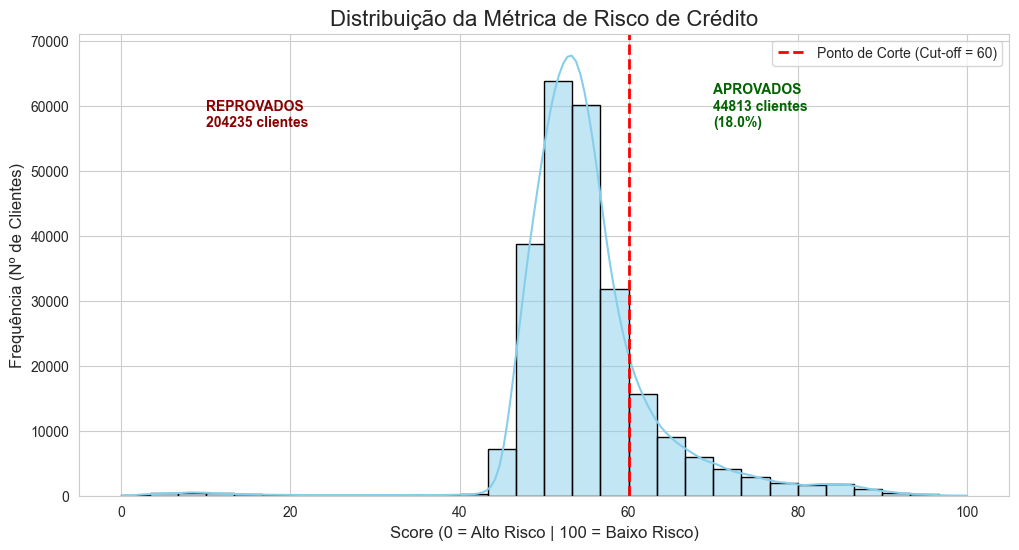


RESUMO DA DECISÃO DE CRÉDITO
Total de Clientes Analisados: 249048
Clientes Aprovados (Score >= 60): 44813 (17.99%)
Clientes Reprovados (Score < 60): 204235 (82.01%)
Score Médio da Carteira: 55.32


In [7]:
#======================================================
# ANÁLISE VISUAL DA DISTRIBUIÇÃO DO SCORE E CUT-OFF >= 60
#======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 1. Carregar a base com as métricas calculadas
# Certifique-se de que o nome do arquivo e o diretório estão corretos
df_plot = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# 2. Configurações Estéticas
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. Plotagem da Distribuição (Histograma + KDE)
ax = sns.histplot(df_plot['METRICA_RISCO'], kde=True, bins=30, color='skyblue', edgecolor='black')

# 4. Adicionando a Linha de Cut-off (Ponto de Corte)
plt.axvline(x=60, color='red', linestyle='--', linewidth=2, label='Ponto de Corte (Cut-off = 60)')

# 5. Cálculo de estatísticas para exibição no gráfico
total = len(df_plot)
aprovados = len(df_plot[df_plot['METRICA_RISCO'] >= 60])
reprovados = total - aprovados
perc_aprov = (aprovados / total) * 100

# Adicionando textos informativos no gráfico
plt.text(10, plt.ylim()[1]*0.8, f'REPROVADOS\n{reprovados} clientes', color='darkred', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, f'APROVADOS\n{aprovados} clientes\n({perc_aprov:.1f}%)', color='darkgreen', fontweight='bold')

# 6. Títulos e Eixos
plt.title('Distribuição da Métrica de Risco de Crédito', fontsize=16)
plt.xlabel('Score (0 = Alto Risco | 100 = Baixo Risco)', fontsize=12)
plt.ylabel('Frequência (Nº de Clientes)', fontsize=12)
plt.legend(loc='upper right')

# 7. Salvar o gráfico para o relatório
if not os.path.exists('analise_exploratoria'):
    os.makedirs('analise_exploratoria')
plt.savefig('analise_exploratoria/distribuicao_metrica_risco.png', dpi=300, bbox_inches='tight')

plt.show()

# 8. Tabela de Resumo para o Trabalho
print("\n" + "="*40)
print("RESUMO DA DECISÃO DE CRÉDITO")
print("="*40)
print(f"Total de Clientes Analisados: {total}")
print(f"Clientes Aprovados (Score >= 60): {aprovados} ({perc_aprov:.2f}%)")
print(f"Clientes Reprovados (Score < 60): {reprovados} ({100 - perc_aprov:.2f}%)")
print(f"Score Médio da Carteira: {df_plot['METRICA_RISCO'].mean():.2f}")
print("="*40)

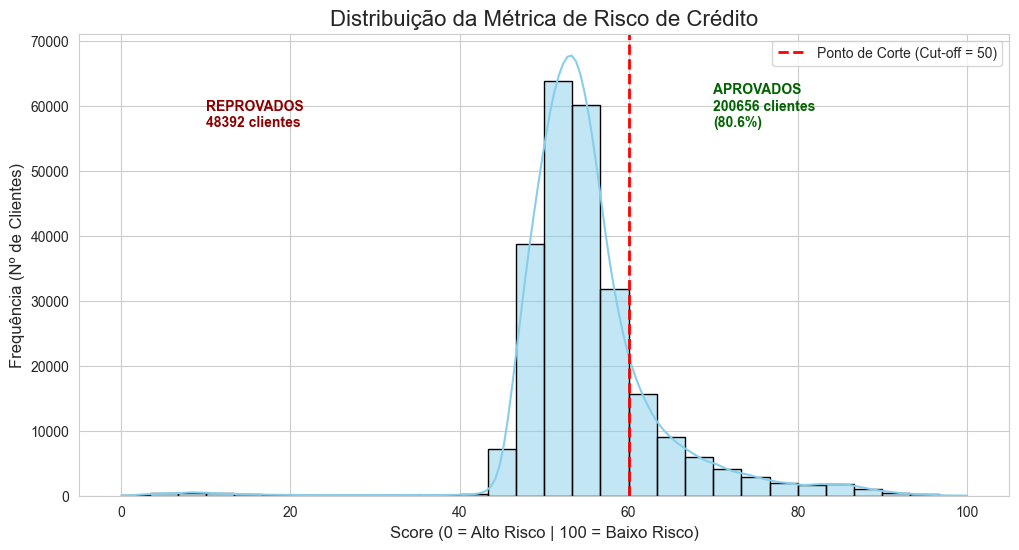


RESUMO DA DECISÃO DE CRÉDITO
Total de Clientes Analisados: 249048
Clientes Aprovados (Score >= 50): 200656 (80.57%)
Clientes Reprovados (Score < 50): 48392 (19.43%)
Score Médio da Carteira: 55.32


In [8]:
#======================================================
# ANÁLISE VISUAL DA DISTRIBUIÇÃO DO SCORE E CUT-OFF >= 50
#======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 1. Carregar a base com as métricas calculadas
# Certifique-se de que o nome do arquivo e o diretório estão corretos
df_plot = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# 2. Configurações Estéticas
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. Plotagem da Distribuição (Histograma + KDE)
ax = sns.histplot(df_plot['METRICA_RISCO'], kde=True, bins=30, color='skyblue', edgecolor='black')

# 4. Adicionando a Linha de Cut-off (Ponto de Corte)
plt.axvline(x=60, color='red', linestyle='--', linewidth=2, label='Ponto de Corte (Cut-off = 50)')

# 5. Cálculo de estatísticas para exibição no gráfico
total = len(df_plot)
aprovados = len(df_plot[df_plot['METRICA_RISCO'] >= 50])
reprovados = total - aprovados
perc_aprov = (aprovados / total) * 100

# Adicionando textos informativos no gráfico
plt.text(10, plt.ylim()[1]*0.8, f'REPROVADOS\n{reprovados} clientes', color='darkred', fontweight='bold')
plt.text(70, plt.ylim()[1]*0.8, f'APROVADOS\n{aprovados} clientes\n({perc_aprov:.1f}%)', color='darkgreen', fontweight='bold')

# 6. Títulos e Eixos
plt.title('Distribuição da Métrica de Risco de Crédito', fontsize=16)
plt.xlabel('Score (0 = Alto Risco | 100 = Baixo Risco)', fontsize=12)
plt.ylabel('Frequência (Nº de Clientes)', fontsize=12)
plt.legend(loc='upper right')

# 7. Salvar o gráfico para o relatório
if not os.path.exists('analise_exploratoria'):
    os.makedirs('analise_exploratoria')
plt.savefig('analise_exploratoria/distribuicao_metrica_risco.png', dpi=300, bbox_inches='tight')

plt.show()

# 8. Tabela de Resumo para o Trabalho
print("\n" + "="*40)
print("RESUMO DA DECISÃO DE CRÉDITO")
print("="*40)
print(f"Total de Clientes Analisados: {total}")
print(f"Clientes Aprovados (Score >= 50): {aprovados} ({perc_aprov:.2f}%)")
print(f"Clientes Reprovados (Score < 50): {reprovados} ({100 - perc_aprov:.2f}%)")
print(f"Score Médio da Carteira: {df_plot['METRICA_RISCO'].mean():.2f}")
print("="*40)

Balanceando classes com SMOTE...
Treinando Árvore de Decisão e K-NN...


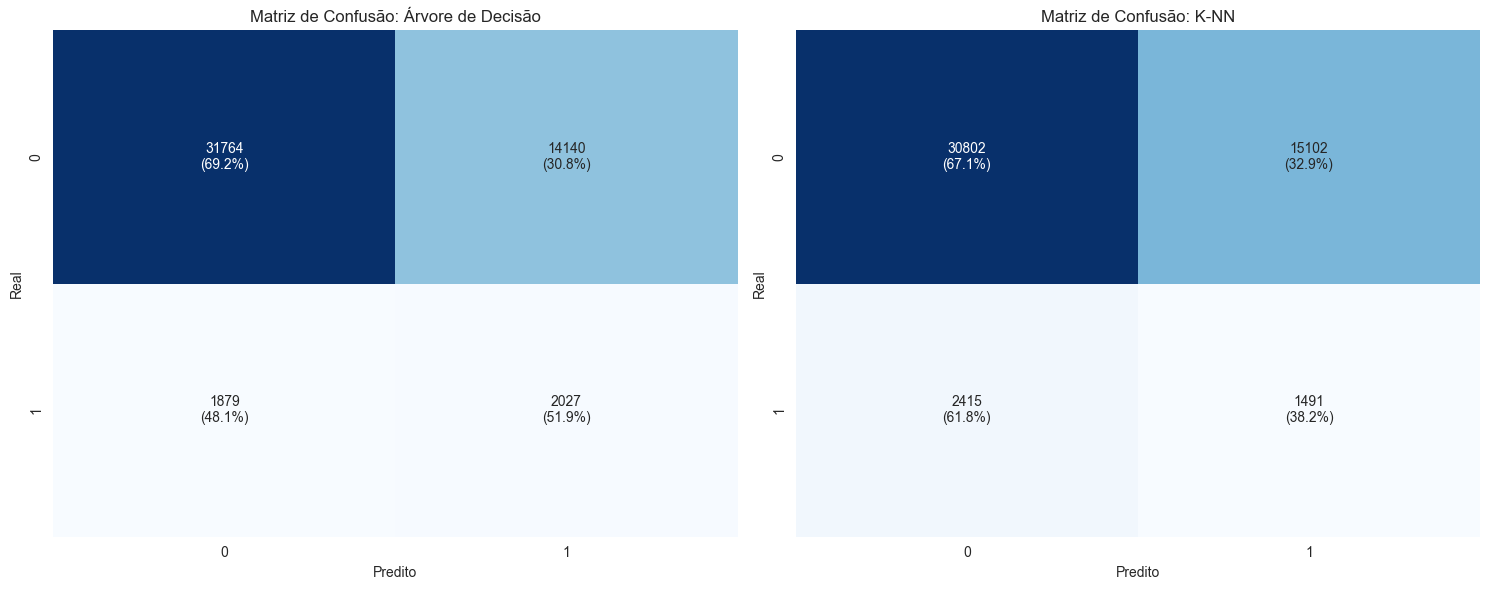


--- RELATÓRIO DE DESEMPENHO (ÁRVORE) ---
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     45904
           1       0.13      0.52      0.20      3906

    accuracy                           0.68     49810
   macro avg       0.53      0.61      0.50     49810
weighted avg       0.88      0.68      0.75     49810


--- RELATÓRIO DE DESEMPENHO (K-NN) ---
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     45904
           1       0.09      0.38      0.15      3906

    accuracy                           0.65     49810
   macro avg       0.51      0.53      0.46     49810
weighted avg       0.86      0.65      0.73     49810



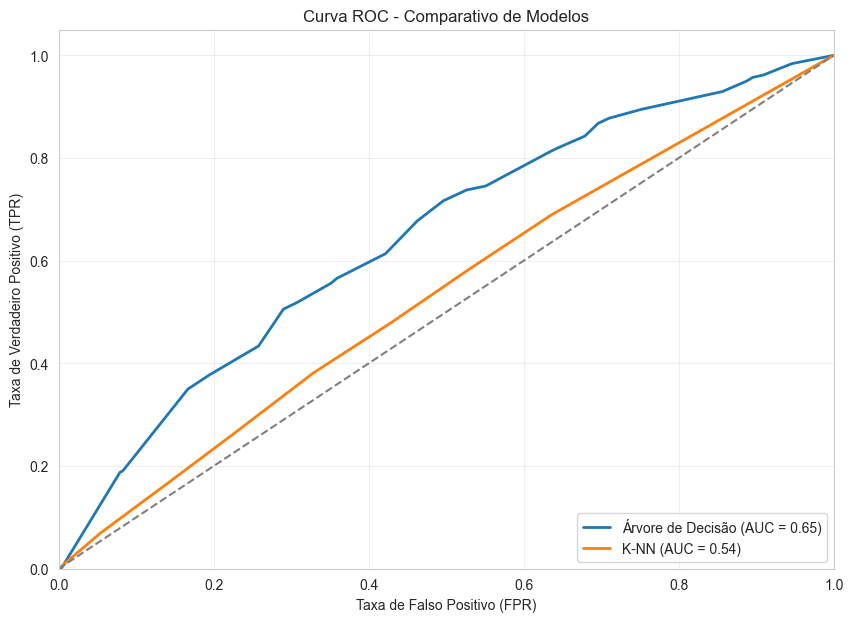

In [9]:
#==============================================================================
# MACHINE LEARNING: TREINAMENTO K-NN e ÁRVORE DE DECISÃO, AVALIAÇÃO E ROC CURVE
#==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc, accuracy_score)
from imblearn.over_sampling import SMOTE # Necessário instalar: pip install imbalanced-learn

# 1. CARREGAR E PREPARAR OS DADOS
df = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# Definir Features (X) e Target (y)
# Removemos IDs, o Target e as colunas calculadas (para evitar vazamento de dados/leakage)
cols_excluir = ['SK_ID_CURR', 'TARGET', 'METRICA_RISCO', 'DECISAO_CREDITO', 'PONTUACAO_BRUTA', 'DAYS_BIRTH']
X = df.drop(columns=cols_excluir)
y = df['TARGET']

# 2. DIVISÃO TREINO E TESTE (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 3. BALANCEAMENTO DE CLASSES (SMOTE)
# Como temos poucos inadimplentes, criamos exemplos sintéticos para equilibrar o treino
print("Balanceando classes com SMOTE...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 4. TREINAMENTO DOS MODELOS
print("Treinando Árvore de Decisão e K-NN...")
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=42) # Árvore limitada para evitar Overfitting
clf_knn = KNeighborsClassifier(n_neighbors=7)

clf_tree.fit(X_train_bal, y_train_bal)
clf_knn.fit(X_train_bal, y_train_bal)

# 5. FUNÇÃO PARA PLOTAR MATRIZ DE CONFUSÃO COM PERCENTUAIS
def plot_conf_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Cálculo do percentual por classe
    
    labels = [f'{val}\n({perc:.1%})' for val, perc in zip(cm.flatten(), cm_perc.flatten())]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Matriz de Confusão: {title}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')

# 6. FUNÇÃO PARA PLOTAR CURVA ROC
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (FPR)')
    plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
    plt.title('Curva ROC - Comparativo de Modelos')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('analise_exploratoria/curva_roc_modelos.png')

# 7. GERAÇÃO DOS RESULTADOS VISUAIS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predições
y_pred_tree = clf_tree.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

plot_conf_matrix(y_test, y_pred_tree, 'Árvore de Decisão', axes[0])
plot_conf_matrix(y_test, y_pred_knn, 'K-NN', axes[1])

plt.tight_layout()
plt.savefig('analise_exploratoria/matrizes_confusao.png')
plt.show()

# Gerar Curva ROC
models_dict = {'Árvore de Decisão': clf_tree, 'K-NN': clf_knn}
plot_roc_curve(models_dict, X_test, y_test)

print("\n--- RELATÓRIO DE DESEMPENHO (ÁRVORE) ---")
print(classification_report(y_test, y_pred_tree))

print("\n--- RELATÓRIO DE DESEMPENHO (K-NN) ---")
print(classification_report(y_test, y_pred_knn))

Estatística de Hopkins: 0.9906


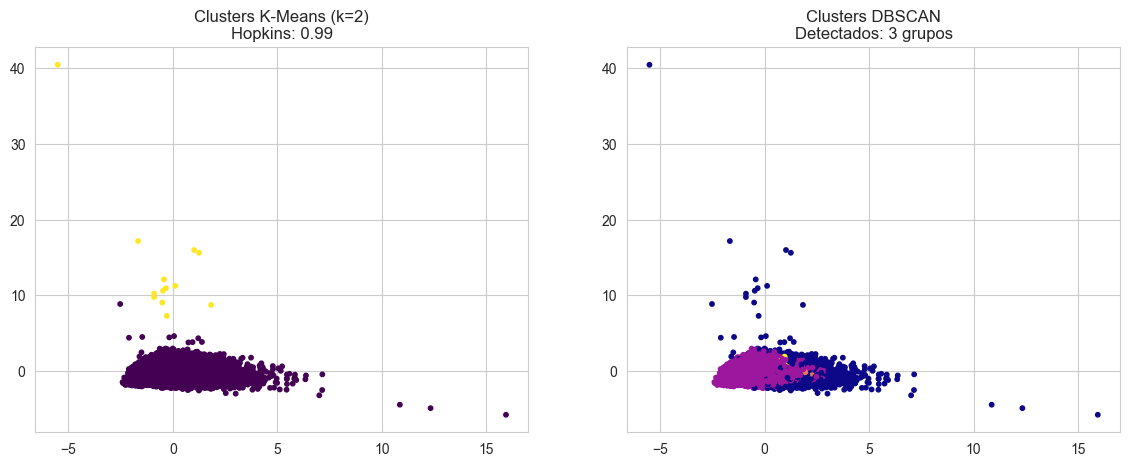

In [10]:
#============================
# Clasterização e validação
#============================ 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from random import sample

# 1. CARREGAMENTO DOS DADOS
try:
    df = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')
except FileNotFoundError:
    print("Arquivo não encontrado. Certifique-se de que o caminho está correto.")

# 2. SELEÇÃO DE ATRIBUTOS PARA CLUSTERIZAÇÃO
# Selecionamos os pilares de risco definidos na engenharia de atributos
cols_clustering = [
    'AMT_INCOME_TOTAL', 'Idade_Dias', 'Tempo_Relacionamento_Dias', 
    'Creditos_Ativos', 'Divida_atrasada', 'Max_Dias_Atraso', 
    'Taxa_Recusa', 'AMT_CREDIT'
]

# Amostragem para agilizar o cálculo do Hopkins e DBSCAN (se a base for muito grande)
df_sample = df[cols_clustering].sample(n=10000, random_state=42)
X = StandardScaler().fit_transform(df_sample)

# 3. ESTATÍSTICA DE HOPKINS
def hopkins_statistic(X):
    """
    Calcula a tendência de clusterização. 
    H próximo de 1: Alta tendência de agrupamento.
    H próximo de 0.5: Dados aleatórios.
    """
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n) # Amostra de 10%
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    # Distâncias de pontos aleatórios no espaço do dataset para seus vizinhos mais próximos
    rand_X = sample(range(0, n, 1), m)
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2)
        ujd.append(u_dist[0][0])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return H

h_stat = hopkins_statistic(X)
print(f"Estatística de Hopkins: {h_stat:.4f}")

# 4. K-MEANS (Forçado em 2 grupos)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X)

# 5. DBSCAN
# Nota: DBSCAN não aceita 'n_clusters'. Ajustamos 'eps' para tentar obter 2 grupos principais.
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X)
n_clusters_db = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)

# 6. VISUALIZAÇÃO COM PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', s=10)
plt.title(f'Clusters K-Means (k=2)\nHopkins: {h_stat:.2f}')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_dbscan, cmap='plasma', s=10)
plt.title(f'Clusters DBSCAN\nDetectados: {n_clusters_db} grupos')

plt.savefig('analise_exploratoria/clusterizacao_comparativa.png')
plt.show()

In [ ]:
#============================================
# Comparação entre os perfis na clusterização
#============================================

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Carregar os dados
df = pd.read_csv('integracao/base_trabalho_metricas_final.csv', sep=';')

# 2. Selecionar atributos para a clusterização
cols_cluster = [
    'AMT_INCOME_TOTAL', 'Idade_Dias', 'Tempo_Relacionamento_Dias', 
    'Creditos_Ativos', 'Divida_atrasada', 'Max_Dias_Atraso', 
    'Taxa_Recusa', 'AMT_CREDIT'
]

# 3. Executar o K-Means (K=2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols_cluster])

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['CLUSTER'] = kmeans.fit_predict(X_scaled)

# 4. Calcular as médias por Cluster
# Incluímos TARGET e METRICA_RISCO para validar a eficácia
analise_clusters = df.groupby('CLUSTER')[cols_cluster + ['TARGET', 'METRICA_RISCO']].mean().T
analise_clusters.columns = ['Cluster_0', 'Cluster_1']

# 5. Calcular a diferença percentual entre os grupos
analise_clusters['Diferenca_Abs'] = (analise_clusters['Cluster_1'] - analise_clusters['Cluster_0']).abs()

print("--- COMPARAÇÃO DE PERFIS POR CLUSTER ---")
print(analise_clusters)

# Exportar para CSV para facilitar a inclusão no relatório
analise_clusters.to_csv('integracao/comparativo_clusters_perfis.csv', sep=';')

--- COMPARAÇÃO DE PERFIS POR CLUSTER ---
                              Cluster_0     Cluster_1  Diferenca_Abs
AMT_INCOME_TOTAL               0.025336     -0.019841       0.045178
Idade_Dias                 18884.434094  12848.520054    6035.914040
Tempo_Relacionamento_Dias   1342.226783    775.599548     566.627235
Creditos_Ativos                0.000000      0.000000       0.000000
Divida_atrasada                0.004597     -0.001070       0.005667
Max_Dias_Atraso                1.593657      0.336381       1.257276
Taxa_Recusa                    0.000000      0.000000       0.000000
AMT_CREDIT                     0.257071     -0.305806       0.562876
TARGET                         0.055421      0.105436       0.050015
METRICA_RISCO                 57.660715     52.578562       5.082153
